In [1]:
%matplotlib inline

from pathlib import Path
import random
import decimal

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import binom
from scipy.stats import distributions as dist
from statsmodels.stats.power import NormalIndPower


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Solving the peeking problem with Group Sequential Testing Techniques

## Power Calculation

In [2]:
effect_size = statsmodels.stats.proportion.proportion_effectsize(0.21, 0.20)  # Set your desired effect size
alpha = 0.05       # Set your desired significance level
power = 0.8     # Set your desired power level
ratio = 1.0        # Set the ratio of sample sizes (if applicable)

sample_size = NormalIndPower().solve_power(effect_size=effect_size, alpha=alpha, nobs1=None, power=power, ratio=ratio, alternative='two-sided')
print("Required sample size per variant:", round(sample_size,0))

Required sample size per variant: 25580.0


# False Positives

In [3]:
# function to select the z-value for each peek, based on the table proposed by O'brien and Flemming
def obrien_z(alpha, n_peeks, peek):
  df = pd.DataFrame(columns=('alpha','n_peeks','z_values'))
  df.loc[0] = [0.05, 2, [2.963,1.969]]
  df.loc[1] = [0.05, 3, [3.710,2.511,1.993]]
  df.loc[2] = [0.05, 4, [4.333,2.963,2.359,2.014]]
  df.loc[3] = [0.05, 5, [4.877,3.357,2.680,2.290,2.031]]
  df.loc[4] = [0.05, 6, [5.367,3.711,2.970,2.539,2.252,2.045]]
  df.loc[5] = [0.05, 8, [6.232,4.331,3.481,2.980,2.644,2.401,2.215,2.066]]
  df.loc[6] = [0.01, 4, [5.493,3.802,3.044,2.603]]
  df.loc[7] = [0.01, 6, [6.776,4.740,3.803,3.257,2.892,2.626]]
  df.loc[8] = [0.01, 8, [8.000,8.000,4.442,3.807,3.381,3.071,2.833,2.643]]
  df = df.query("alpha == @alpha  and n_peeks == @n_peeks")
  return df['z_values'].reset_index().loc[0][1][peek-1]

In [4]:
# Set seed for reproducibility
np.random.seed(42)

df = pd.DataFrame(columns=('week','n', 'A', 'B', 'statsig', 'statsig_seq', 'impact', 'impact_seq'))
n_tests = 1000
n_obs = round(sample_size,0)
alpha = 0.05
n_peeks = 8

for k in range(n_tests):

  # sample 2 times from the control binomial distribution
  n, p = round(n_obs/n_peeks,0), .2 # number of trials, probability of each trial
  tests = 2
  samples = np.random.binomial(n, p, tests)
  success_A, success_B = samples[0], samples[1]
  trials_A = trials_B = n

  count = np.array([success_B, success_A])
  nobs = np.array([trials_B, trials_A])
  z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')
  result = 1 if p_value < alpha else 0
  result_sequential = 1 if z_stat > obrien_z(alpha, n_peeks, 1) else 0
  impact = (success_B / success_A) -1 if p_value < alpha  else None
  impact_sequential = (success_B / success_A) -1 if z_stat > obrien_z(alpha, n_peeks, 1)   else None

  week = [1, trials_A, success_A, success_B, result, result_sequential, impact, impact_sequential]
  df.loc[len(df)] = week

for j in range(n_peeks-1):
  for k in range(n_tests):
    # Followup weeks
    n, p = n_obs/n_peeks, .2 # number of trials, probability of each trial
    tests = 2
    samples = np.random.binomial(n, p, tests)
    success_A, success_B = samples[0], samples[1]
    trials_A = trials_B = n

    suc_A_week_ant = df[df.week == j+1]['A'].loc[(n_tests*j)+k]
    suc_B_week_ant = df[df.week == j+1]['B'].loc[(n_tests*j)+k]
    trials_ant = df[df.week == j+1]['n'].loc[(n_tests*j)+k]
    result_ant = df[df.week == j+1]['statsig'].loc[(n_tests*j)+k]
    result_sequential_ant = df[df.week == j+1]['statsig_seq'].loc[(n_tests*j)+k]

    success_A = success_A + suc_A_week_ant
    success_B = success_B + suc_B_week_ant
    trials_A = trials_ant + trials_A
    trials_B = trials_ant + trials_B

    # Significance testing
    count = np.array([success_B , success_A ])
    nobs = np.array([trials_B, trials_A])
    z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')
    result = 1 if p_value < alpha else 0
    result_sequential = 1 if z_stat > obrien_z(alpha, n_peeks, j+2)  else 0
    result = result + result_ant
    result_sequential = result_sequential + result_sequential_ant
    impact = (success_B / success_A) -1 if p_value < alpha  else None
    impact_sequential = (success_B / success_A) -1 if z_stat > obrien_z(alpha, n_peeks, j+2) else None


    week = [j+2, trials_A, success_A, success_B, result, result_sequential, impact, impact_sequential]
    df.loc[len(df)] = week

# Falso positvo por semana
df = df.assign(statsig_final=np.where(df.statsig > 0, 1, 0))
df = df.assign(statsig_final_seq=np.where(df.statsig_seq > 0, 1, 0))
df_grouped = df.groupby('week').agg({'statsig_final':'mean', 'statsig_final_seq':'mean'})
df_grouped

,statsig_final,statsig_final_seq
week,,
1.0,0.063,0.000
2.0,0.092,0.000
3.0,0.111,0.000
4.0,0.126,0.000
5.0,0.144,0.003
6.0,0.156,0.010
7.0,0.161,0.015
8.0,0.169,0.024


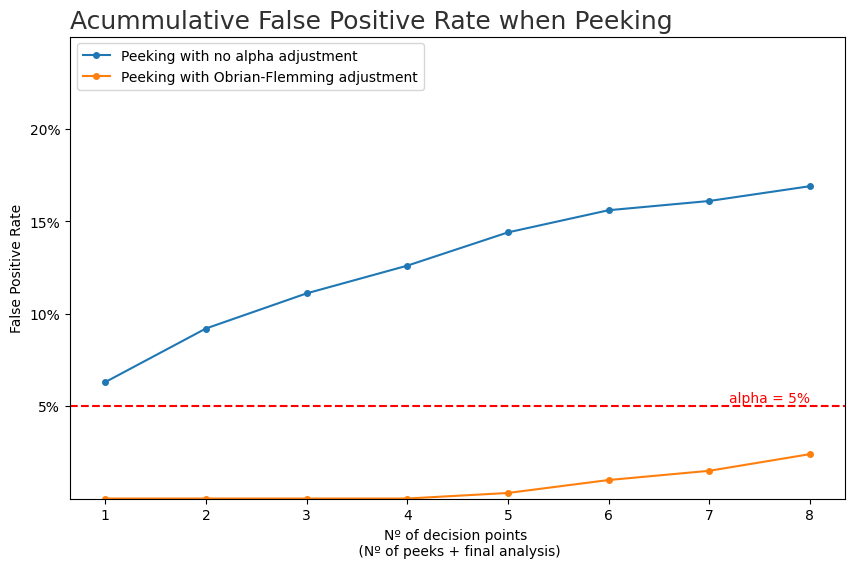

In [5]:
# Set plot size
plt.figure(figsize=(10,6))

# Select the number data to show on the plot
df_plot = df_grouped.reset_index()

# Plot the line plot
plt.plot(df_plot['week'],df_plot['statsig_final'],label='Peeking with no alpha adjustment', marker='o', markersize=4)
plt.plot(df_plot['week'],df_plot['statsig_final_seq'],label='Peeking with Obrian-Flemming adjustment', marker='o', markersize=4)


# Add a horizontal line at y=0.05
plt.axhline(y=0.05, color='r', linestyle='--')

# Add text 'alpha = 0.05' at y=0.05 to the right
plt.text(8, 0.052, 'alpha = 5%', color='red', horizontalalignment='right')

# Set the labels and title
plt.xlabel('Nº of decision points \n (Nº of peeks + final analysis)')
plt.ylabel('False Positive Rate')
plt.title(label='Acummulative False Positive Rate when Peeking',
          fontsize=18,
          color='#303030',
          loc='left')

# Format y-axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
plt.ylim(0.0, 0.25)
plt.yticks(ticks=[0.05,0.1, 0.15, 0.2])

# Set x-axis ticks to show only the numbers of peeks selected
#plt.xticks(ticks=[1,4,8,16,24,32])

# Show the plot
plt.grid(False)
plt.legend(loc='upper left')
plt.show()

# Power

In [6]:
# Set seed for reproducibility
np.random.seed(42)

# parametros do teste
n_tests = 1000 # quantos testes AA vamos simular
n_obs = round(sample_size,0) # tamanho de amostra por variante em cada teste
conv_control = 0.2 # taxa de conversão real da população controle
conv_variant = 0.21 # taxa de conversão real da população variante
alpha = 0.05 # nível de significância

results = []
impacts = []

for k in range(n_tests):
  # sample for the prior (equivalente a metade do tamanho de amostra do teste)
  n, p = n_obs/2, conv_control # number of trials, probability of each trial
  tests = 1
  samples = np.random.binomial(n, p, tests)
  prior_success = samples[0]
  prior_failure = n - prior_success

  # sample 1 time from the control binomial distribution
  n, p = n_obs, conv_control
  tests = 1 # calcular o valor da tx de converão do prior, da controle e da variante
  samples = np.random.binomial(n, p, tests) # sortear os 3 valores
  success_A  = samples[0]
  trials_A = n

  # sample 1 time from the improved binomial distribution
  n, p = n_obs, conv_variant # number of trials, probability of each trial
  tests = 1 # calcular tx de conversão da variante
  samples = np.random.binomial(n, p, tests)
  success_B = samples[0]
  trials_B = n

  # Test 3: Frequentist Z-test for proportions
  count = np.array([success_B, success_A])
  nobs = np.array([trials_B, trials_A])
  z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')
  p_value = 1 if p_value <= alpha else 0
  impact = (success_B / success_A) -1 if p_value == 1 else None
  results.append(p_value)
  impacts.append(impact)

print(f'Poder: {(pd.Series(results).mean())*100}%, com impacto médio de {pd.Series(impacts).mean()*100}%')

Poder: 77.7%, com impacto médio de 5.627484386597907%


In [7]:
# Set seed for reproducibility
np.random.seed(42)

df = pd.DataFrame(columns=('week','n', 'A', 'B', 'statsig', 'statsig_seq', 'impact', 'impact_sequential'))
n_tests = 1000
n_obs = round(sample_size,0)
conv_control = 0.2
conv_variant = 0.21
alpha = 0.05
#alpha_sequential = [6.991,4.899,3.930,3.367,2.989,2.715,2.504,2.336,2.197,2.081]
n_peeks = 8

for k in range(n_tests):
  # sample 2 times from the control binomial distribution
  n, p = round(n_obs/n_peeks,0), conv_control # number of trials, probability of each trial
  tests = 1
  samples = np.random.binomial(n, p, tests)
  success_A = samples[0]
  # sample 1 time from the improved binomial distribution
  n2, p2 = n_obs/n_peeks, conv_variant # number of trials, probability of each trial
  tests2 = 1
  samples_2 = np.random.binomial(n2, p2, tests2)
  success_B = samples_2[0]
  trials_A = trials_B = n

  count = np.array([success_B, success_A])
  nobs = np.array([trials_B, trials_A])
  z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')
  result = 1 if p_value < alpha else 0
  result_sequential = 1 if z_stat > obrien_z(alpha, n_peeks, 1) else 0
  impact = (success_B / success_A) -1 if p_value < alpha  else None
  impact_sequential = (success_B / success_A) -1 if z_stat > obrien_z(alpha, n_peeks, 1)   else None

  week = [1, trials_A, success_A, success_B, result, result_sequential, impact, impact_sequential]
  df.loc[len(df)] = week

for j in range(n_peeks-1):
  for k in range(n_tests):
    # Followup weeks
    # sample 2 times from the control binomial distribution
    n, p = round(n_obs/n_peeks,0), conv_control # number of trials, probability of each trial
    tests = 1
    samples = np.random.binomial(n, p, tests)
    success_A = samples[0]
    # sample 1 time from the improved binomial distribution
    n2, p2 = n_obs/n_peeks, conv_variant # number of trials, probability of each trial
    tests2 = 1
    samples_2 = np.random.binomial(n2, p2, tests2)
    success_B = samples_2[0]
    trials_A = trials_B = n

    suc_A_week_ant = df[df.week == j+1]['A'].loc[(n_tests*j)+k]
    suc_B_week_ant = df[df.week == j+1]['B'].loc[(n_tests*j)+k]
    trials_ant = df[df.week == j+1]['n'].loc[(n_tests*j)+k]
    result_ant = df[df.week == j+1]['statsig'].loc[(n_tests*j)+k]
    result_sequential_ant = df[df.week == j+1]['statsig_seq'].loc[(n_tests*j)+k]

    success_A = success_A + suc_A_week_ant
    success_B = success_B + suc_B_week_ant
    trials_A = trials_ant + trials_A
    trials_B = trials_ant + trials_B

    count = np.array([success_B , success_A ])
    nobs = np.array([trials_B, trials_A])
    z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')
    result = 1 if p_value < alpha else 0
    result_sequential = 1 if z_stat > obrien_z(alpha, n_peeks, j+2)  else 0
    result = result + result_ant
    result_sequential = result_sequential + result_sequential_ant
    impact = (success_B / success_A) -1 if p_value < alpha  else None
    impact_sequential = (success_B / success_A) -1 if z_stat > obrien_z(alpha, n_peeks, j+2) else None


    week = [j+2, trials_A, success_A, success_B, result, result_sequential, impact, impact_sequential]
    df.loc[len(df)] = week

# Poder do teste por semana
df = df.assign(statsig_final=np.where(df.statsig > 0, 1, 0))
df = df.assign(statsig_final_seq=np.where(df.statsig_seq > 0, 1, 0))
df_grouped = df.groupby('week').agg({'statsig_final':'mean', 'statsig_final_seq':'mean','impact':'mean', 'impact_sequential':'mean'})
df_grouped

,statsig_final,statsig_final_seq,impact,impact_sequential
week,,,,
1.0,0.193,0.000,0.131660,NaN
2.0,0.369,0.002,0.094885,0.169747
3.0,0.493,0.050,0.080705,0.118171
4.0,0.600,0.177,0.072374,0.092555
5.0,0.687,0.368,0.066707,0.077009
6.0,0.759,0.543,0.062444,0.067780
7.0,0.816,0.678,0.058799,0.061769
8.0,0.854,0.785,0.056918,0.057778


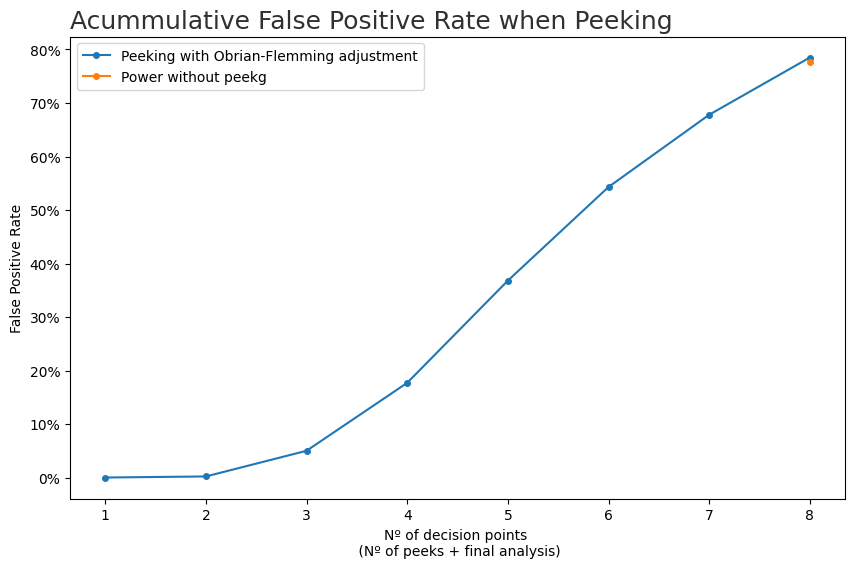

In [8]:
# Add a new column with the power of the fixed sample test
df_grouped['statsig_fixed'] = None
df_grouped.loc[df.index[8], 'statsig_fixed'] = pd.Series(results).mean()

# Set plot size
plt.figure(figsize=(10,6))

# Select the number data to show on the plot
df_plot = df_grouped.reset_index()

# Plot the line plot
#plt.plot(df_plot['week'],df_plot['statsig_final'],label='Peeking with no alpha adjustment', marker='o', markersize=4)
plt.plot(df_plot['week'],df_plot['statsig_final_seq'],label='Peeking with Obrian-Flemming adjustment', marker='o', markersize=4)
plt.plot(df_plot['week'],df_plot['statsig_fixed'],label='Power without peekg', marker='o', markersize=4)

# Set the labels and title
plt.xlabel('Nº of decision points \n (Nº of peeks + final analysis)')
plt.ylabel('False Positive Rate')
plt.title(label='Acummulative False Positive Rate when Peeking',
          fontsize=18,
          color='#303030',
          loc='left')

# Format y-axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))

# Show the plot
plt.grid(False)
plt.legend(loc='upper left')
plt.show()


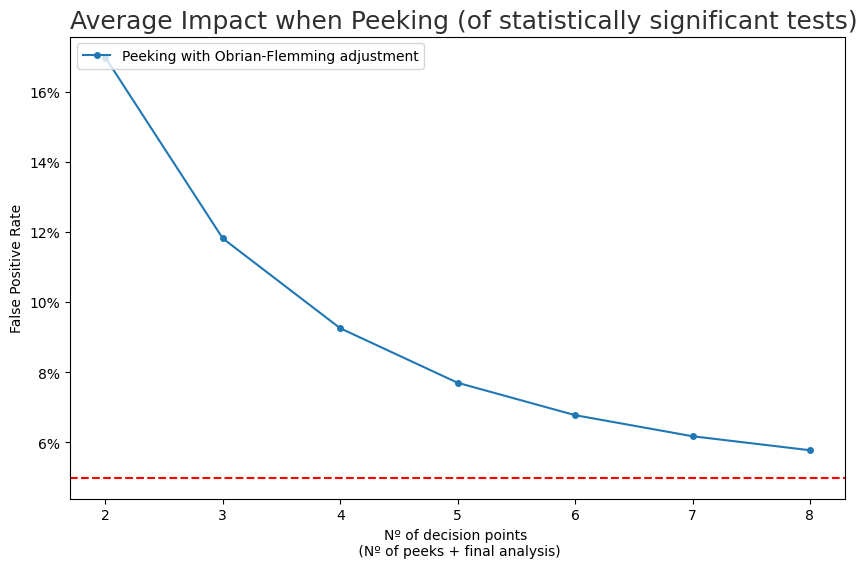

In [9]:
# Set plot size
plt.figure(figsize=(10,6))

# Select the number data to show on the plot
df_plot = df_grouped.reset_index()

# Plot the line plot
#plt.plot(df_plot['week'],df_plot['statsig_final'],label='Peeking with no alpha adjustment', marker='o', markersize=4)
plt.plot(df_plot['week'],df_plot['impact_sequential'],label='Peeking with Obrian-Flemming adjustment', marker='o', markersize=4)


# Add a horizontal line at y=0.05
plt.axhline(y=0.05, color='r', linestyle='--')

# Set the labels and title
plt.xlabel('Nº of decision points \n (Nº of peeks + final analysis)')
plt.ylabel('False Positive Rate')
plt.title(label='Average Impact when Peeking (of statistically significant tests)',
          fontsize=18,
          color='#303030',
          loc='left')

# Format y-axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))

# Show the plot
plt.grid(False)
plt.legend(loc='upper left')
plt.show()


# References

https://www.aarondefazio.com/tangentially/?p=83